In [3]:
import sys
import os
from pathlib import Path

#import signal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
matplotlib.use('Qt5Agg')

import logging

from scipy.signal import spectrogram
import rf_tools as rft


ImportError: Cannot load backend 'Qt5Agg' which requires the 'qt' interactive framework, as 'headless' is currently running

In [2]:
# print the current settings of PYTHONPATH
print(f"The PYTHONPATH is: {sys.path}")
# setup logging to save to a file
logging_file = Path.home() / 'log' / 'sdr_get_samples.log'
logging.basicConfig(filename=logging_file, level=logging.DEBUG, format='%(asctime)s %(levelname)s %(funcName)s: %(message)s')

print(matplotlib.rcsetup.all_backends)
print(f"matplotlib rendering backend is {matplotlib.get_backend()}")

The PYTHONPATH is: ['/home/user/src/rf_analysis', '', '/home/user/src/rf_analysis/.rf_analysis/lib/python3.10/site-packages', '/usr/lib/python3', '/usr/lib/python3/dist-packages', '/home/user/.pyenv/versions/3.10.4/lib/python310.zip', '/home/user/.pyenv/versions/3.10.4/lib/python3.10', '/home/user/.pyenv/versions/3.10.4/lib/python3.10/lib-dynload']
['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
matplotlib rendering backend is module://matplotlib_inline.backend_inline


In [4]:
new_file_path = Path.home() / 'data' / 'sdr_db_t1'
sdr_db = rft.sdr_load_db(new_file_path)
print(f"Loaded {len(sdr_db)} records from {new_file_path}")

Loaded 2 records from /home/user/data/sdr_db_t1


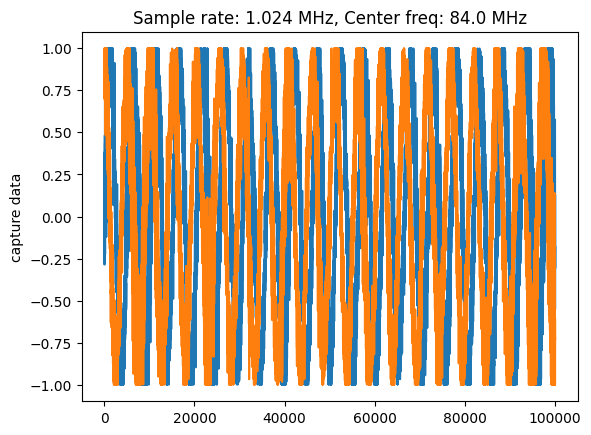

In [5]:
(x, full_file_name)=rft.load_capture_file(sdr_db[0])
sample_rate = sdr_db[0]['sample_rate']
center_freq_Hz = sdr_db[0]['center_freq_Hz']

import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.real(x[0:1000]))
plt.plot(np.imag(x[0:1000]))
plt.xlabel('Sample number')
plt.ylabel('IQ magnitude')
plt.legend(['Real', 'Imaginary'])
plt.title('Sample rate = ' + str(sample_rate/1e6) + ' MHz, Center frequency = ' + str(center_freq_Hz/1e6) + ' MHz')
plt.show()

In [7]:
from scipy.signal import spectrogram
(frequencies, times, spectrogram_data)= spectrogram(x, fs=sample_rate, nperseg=128, noverlap=64,return_onesided=False, mode='complex', scaling='density')

# Why fftshift is needed https://github.com/scipy/scipy/issues/5757#issuecomment-259482424
frequencies = np.fft.fftshift(frequencies)
# add the center_freq_Hz to the frequencies to get the actual frequency values
frequencies = frequencies + center_freq_Hz
# convert to MHz
frequencies = frequencies / 1e6

spectrogram_data = np.fft.fftshift(spectrogram_data, axes=0)

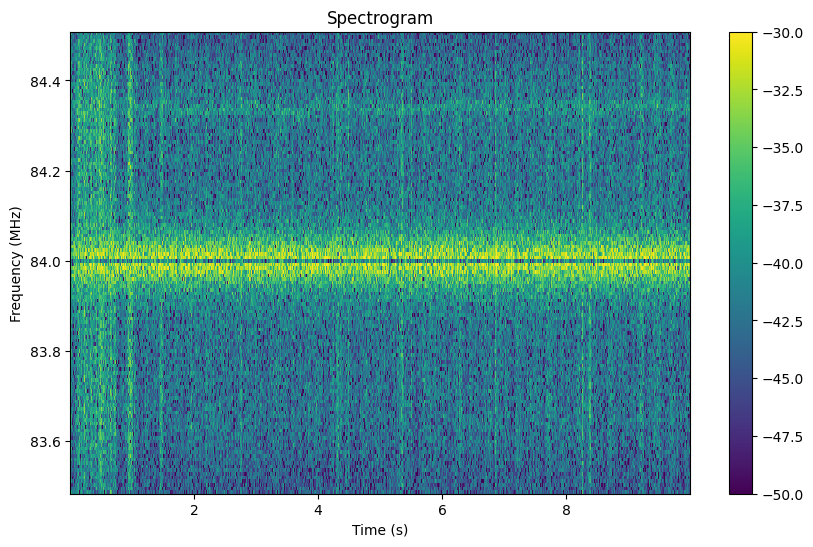

In [8]:
# create a unique colormap to use for the spectrogram plot
cmap = plt.get_cmap('viridis')

fig_width = 10
fig_height = 6

fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_subplot(111)
ph=ax.pcolormesh(times,frequencies, 10*np.log10(np.abs(spectrogram_data)), cmap=cmap)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (MHz)')
#set the colorbar
fig.colorbar(ph, ax=ax)

ax.set_title('Spectrogram')

# set the color bar limits to the range of the data values
#ph.set_clim(np.min(10*np.log10(np.abs(spectrogram_data))), np.max(10*np.log10(np.abs(spectrogram_data))))
ph.set_clim(-50, -30)

plt.show()

In [ ]:
# Desired figure size: (width, height)
fig_width = 10  # in inches
fig_height = 6  # in inches

# Why fftshift is needed https://github.com/scipy/scipy/issues/5757#issuecomment-259482424
frequencies = np.fft.fftshift(frequencies)
spectrogram_data = np.fft.fftshift(spectrogram_data, axes=0)
# create a unique colormap to use for the spectrogram plot
cmap = plt.get_cmap('viridis')

plt.figure(figsize=(fig_width, fig_height))
plt.pcolormesh(times,frequencies, 10*np.log10(np.abs(spectrogram_data)), cmap=cmap)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')
plt.title('Spectrogram')

# Save the figure to a PNG file
plt.savefig('spectrogram.png')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create some data
data1 = np.random.rand(10, 10)
data2 = np.random.randn(10, 10) - 0.5  # Data to overlay

# Mask data2 except for a rectangular strip in the middle
strip_top = 3
strip_bottom = 7

data2[:strip_top, :] = np.nan
data2[strip_bottom:, :] = np.nan

fig, ax = plt.subplots()

# Plot the pcolormesh data
c1 = ax.pcolormesh(data1, cmap='viridis', zorder=1)

# Plot the imshow data
c2 = ax.imshow(data2, cmap='inferno', alpha=0.5, interpolation='none', zorder=2)

# Add colorbars
fig.colorbar(c1, ax=ax, label="Data 1")
fig.colorbar(c2, ax=ax, label="Data 2")

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.draw import polygon_perimeter

# Create some sample data
data1 = np.random.rand(10, 10)
data2 = np.random.randn(10, 10)

# Threshold data2 to identify regions of interest
threshold = 0.5
binary = data2 > threshold

# Label regions
labeled = label(binary)

# Create a boundary map
boundary = np.zeros_like(data2, dtype=np.uint8)
for region in regionprops(labeled):
    if region.area >= 1:  # or any minimum area criterion you'd like
        r, c = polygon_perimeter(region.coords[:,0], region.coords[:,1], labeled.shape)
        boundary[r, c] = 1

fig, ax = plt.subplots()
ax.pcolormesh(data1, cmap='viridis')
ax.imshow(boundary, cmap='cool', alpha=0.7, interpolation='none')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create some sample data
data = np.random.rand(10, 10)

# Create the viridis colormap
viridis = plt.cm.get_cmap('viridis', 256)

# Create a new colormap with added transparency
newcolors = viridis(np.linspace(0, 1, 256))
# Set alpha from opaque to transparent
newcolors[:,-1] = np.linspace(1, 0, 256)
# Create the new colormap from the array
newcmp = mcolors.ListedColormap(newcolors)

# Plot the data
fig, ax = plt.subplots()
c = ax.pcolormesh(data, cmap=newcmp)
fig.colorbar(c, ax=ax)
plt.show()


In [ ]:
full_image_file_name_list =  rft.render_spectrogram_to_file(sdr_db, new_file_path='/home/user/data/sdr_db_t1/')